## Generate smoke estimates

This is the main notebook to generate the smoke estimates for Alexandria from 1964-2021. This notebook will clean and save the wildfire data and based on the smoke estimate formula will generate the smoke estimates for the wildfire seasons. The final smoke estimates are calculated for every row in the data and is stored in 'intermediary_files/smoke_estimates.csv'

## License

Snippets from this code to get distances for fires was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - August 16, 2024

Rest of the code is under MIT license

## Dependencies

This notebook has dependencies on [Pyproj](https://pyproj4.github.io/pyproj/stable/index.html), the [geojson](https://pypi.org/project/geojson/) module and on the wildfire user, compute distance modules present in the helper folder. I have added the pip install commands for reproducibility and it will capture it for future use.

In [ ]:
%%capture
%pip install geojson
%pip install matplotlib
%pip install numpy
%pip install statsmodels
%pip install sklearn
%pip install requests

In [ ]:
#
#    IMPORTS
# 

#    Import some standard python modules
import os, json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#    The 'wildfire' module is a user module. This module is available from the course website. The module
#    includes one object, a Reader, that can be used to read the GeoJSON files associated with the
#    wildefire dataset. The module also contains a sample datafile that is GeoJSON compliant and that
#    contains a small number of wildfires extracted from the main wildfire dataset.
#    
from helpers.wildfire.Reader import Reader as WFReader
# import the process fire module to compute average and smallest distance
from helpers.compute_distance import process_fire_feature

# Using multiprocessing will help speed up the process of reading data as it parallelizes the task
import multiprocessing

# The 'requests' module is a distribution module for making web requests. If you do not have it already, you'll need to install it
import requests


### Step 0: Data acquisition

You should get the [Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons)](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) dataset. This dataset was collected and aggregated by the US Geological Survey. The dataset is relatively well documented. The dataset provides fire polygons in ArcGIS and GeoJSON formats. 

The data should be downloaded and put under the `raw_data/<USGS_Wildland_Fire_Combined_Dataset.json>` to run the below cell. The size of the data is 2.7GB thus I have not uploaded it to github.

I am analyzing forest fires in [Alexandria, VA](https://en.wikipedia.org/wiki/Alexandria,_Virginia). Alexandria is an independent city (not bound to any county), in the northern region of the Commonwealth of Virginia, United States. The latitude and longitude information is acquired from Wikipedia.

In [1]:
DATA_FILENAME = "../raw_data/USGS_Wildland_Fire_Combined_Dataset.json"

# I have added only one city Alexandria in the city locations as my analysis is only for this one city
CITY_LOCATIONS = {
    'Alexandria' :     {'city'   : 'Alexandria',
                       'latlon' : [38.820450, -77.050552] }}

In [ ]:
#
#    This bit of code opens a new wildfire reader, gets the header information and prints it to the screen
#
print(f"Attempting to open '{DATA_FILENAME}' with wildfire.Reader() object")
wfreader = WFReader(DATA_FILENAME)
print()
#
#    Now print the header - it contains some useful information
#
header_dict = wfreader.header()
header_keys = list(header_dict.keys())
print("The header has the following keys:")
print(header_keys)
print()
print("Header Dictionary")
print(json.dumps(header_dict,indent=4))

The below code is a snippet from Dr. Mcdonalds reference code mentioned in the license

In [ ]:
#
#    This sample code will load the whole sample (extracted data) file, 
#
MAX_FEATURE_LOAD = 100
feature_list = list()
feature_count = 0
# A rewind() on the reader object makes sure we're at the start of the feature list
# This way, we can execute this cell multiple times and get the same result 
wfreader.rewind()
# Now, read through each of the features, saving them as dictionaries into a list
feature = wfreader.next()
while feature:
    feature_list.append(feature)
    feature_count += 1
    # As we're loading a lot of features, print progress
    if (feature_count % 100) == 0:
        print(f"Loaded {feature_count} features")

    feature = wfreader.next()
#
#    Print the number of items (features) we think we loaded
print(f"Loaded a total of {feature_count} features")
#
#    Just a validation check - did all the items we loaded get into the list?
print(f"Variable 'feature_list' contains {len(feature_list)} features")

Loaded 100 features
Loaded 200 features
Loaded 300 features
Loaded 400 features
Loaded 500 features
Loaded 600 features
Loaded 700 features
Loaded 800 features
Loaded 900 features
Loaded 1000 features
Loaded 1100 features
Loaded 1200 features
Loaded 1300 features
Loaded 1400 features
Loaded 1500 features
Loaded 1600 features
Loaded 1700 features
Loaded 1800 features
Loaded 1900 features
Loaded 2000 features
Loaded 2100 features
Loaded 2200 features
Loaded 2300 features
Loaded 2400 features
Loaded 2500 features
Loaded 2600 features
Loaded 2700 features
Loaded 2800 features
Loaded 2900 features
Loaded 3000 features
Loaded 3100 features
Loaded 3200 features
Loaded 3300 features
Loaded 3400 features
Loaded 3500 features
Loaded 3600 features
Loaded 3700 features
Loaded 3800 features
Loaded 3900 features
Loaded 4000 features
Loaded 4100 features
Loaded 4200 features
Loaded 4300 features
Loaded 4400 features
Loaded 4500 features
Loaded 4600 features
Loaded 4700 features
Loaded 4800 features
L

The 'feature_list' variable was created when we read the sample file in a code cell above

The total features in the feature_list are 135061.

In [ ]:
# analyzing single feature in the list, eg feature number 0 in the list
SLOT = 0
wf_feature = feature_list[SLOT]

# Print everyting in this dictionary (i.e., wf_feature) - it's long
print(f"The wildfire feature from slot '{SLOT}' of the loaded 'feature_list'")
print(json.dumps(wf_feature, indent=4))

The wildfire feature from slot '0' of the loaded 'feature_list'
{
    "attributes": {
        "OBJECTID": 1,
        "USGS_Assigned_ID": 1,
        "Assigned_Fire_Type": "Wildfire",
        "Fire_Year": 1860,
        "Fire_Polygon_Tier": 1,
        "Fire_Attribute_Tiers": "1 (1)",
        "GIS_Acres": 3940.20708940724,
        "GIS_Hectares": 1594.5452365353703,
        "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)",
        "Listed_Fire_Types": "Wildfire (1)",
        "Listed_Fire_Names": "Big Quilcene River (1)",
        "Listed_Fire_Codes": "No code provided (1)",
        "Listed_Fire_IDs": "",
        "Listed_Fire_IRWIN_IDs": "",
        "Listed_Fire_Dates": "Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)",
        "Listed_Fire_Causes": "",
        "Listed_Fire_Cause_Class": "Undetermined (1)",
        "Listed_Rx_Reported_Acres": null,
        "Listed_Map_Digitize_Methods": "Other (1)",
        "Listed_Notes": "",
        "Processing

In [ ]:
# print attributes to check what are important features we can use to get the smoke estimate.
wf_feature['attributes']

{'OBJECTID': 1,
 'USGS_Assigned_ID': 1,
 'Assigned_Fire_Type': 'Wildfire',
 'Fire_Year': 1860,
 'Fire_Polygon_Tier': 1,
 'Fire_Attribute_Tiers': '1 (1)',
 'GIS_Acres': 3940.20708940724,
 'GIS_Hectares': 1594.5452365353703,
 'Source_Datasets': 'Comb_National_NIFC_Interagency_Fire_Perimeter_History (1)',
 'Listed_Fire_Types': 'Wildfire (1)',
 'Listed_Fire_Names': 'Big Quilcene River (1)',
 'Listed_Fire_Codes': 'No code provided (1)',
 'Listed_Fire_IDs': '',
 'Listed_Fire_IRWIN_IDs': '',
 'Listed_Fire_Dates': 'Listed Other Fire Date(s): 2006-11-02 - NIFC DATE_CUR field (1)',
 'Listed_Fire_Causes': '',
 'Listed_Fire_Cause_Class': 'Undetermined (1)',
 'Listed_Rx_Reported_Acres': None,
 'Listed_Map_Digitize_Methods': 'Other (1)',
 'Listed_Notes': '',
 'Processing_Notes': '',
 'Wildfire_Notice': 'Wildfire mapping prior to 1984 was inconsistent, infrequent, and done without the aid of more modern fire mapping methods (GPS and satellite imagery). Areas burned prior to 1984 in this dataset repre

It seems like the data does not include exact date so it is difficult to filter for annual fire season but we can use the AQI API to filter for the annual fire season.

In [ ]:
#
#    Every feature has a 'geometry' which specifies geo coordinates that make up each geographic thing
#    In the case of the wildfire data, most wildfires are bounded shapes, circles, squares, etc. This is
#    represented by shapes called 'rings' in GeoJSON.
# 
# Get the geometry for the feature we pulled from the feature_list
wf_geometry = wf_feature['geometry']
# The largest shape (ring) is supposed to be item zero in the list of 'rings'
wf_bigest_ring = wf_geometry['rings'][0]

print(f"The largest ring consists of {len(wf_bigest_ring)} points.")

The largest ring consists of 768 points.


### Step 1: Read and save the wildfire data

The code below uses multithreading which is an approach to run the processes parallely. I have referenced this code from my classmates by collaborating with them. My intital approach was to use a single core for processing which also generates the same result. I have added that code block below to reproduce if there are limitations on running the code on multiple cores.

Note: The code takes about 20-30 minutes to run on multiple cores and 112 minutes to run on single core.

In [10]:
# setting up constants to create the two dataframes for shortest distance and avg distance of fire from the place
place = CITY_LOCATIONS["Alexandria"]
fire_info = {}
fire_errors = {}

The code below uses multiprocessing to speed up the process to get the fire distances and parse the data. To process the fire information I have created a module called compute_distance which we import below. the function 'process_fire_feature' processes individual fires but because the program runs on multiple cores the time for distance compuation is reduced significantly. This code was developed by collaborating with my classmates.

Note: Running this below cell can take about 70-100 minutes depending on how many cores are used to run the program.

In [18]:
%%time
# below code can run the code on multithreading and generate a fire_info dataframe 
# which has a key name year-unique_id-fire_name and value is the dictionary which holds the distance information for that fire.


# Create a multiprocessing pool
pool = multiprocessing.Pool(4) # change the number of cores here

# Prepare input data for the pool
input_data = [(wf_feature, place, i) for i, wf_feature in enumerate(feature_list)]

# Process the fire features in parallel
results = pool.starmap(process_fire_feature, input_data)

# Close the pool and wait for all processes to finish
pool.close()
pool.join()

# Process the results
for result in results:
    key, fire = result
    if isinstance(fire, dict):
        fire_info[key] = fire
    else:
        fire_errors[key] = fire

Error in processing the wildfire data for MICHAEL CROWE (1) from 2010. (Key - 2010-114308-MICHAEL CROWE (1)
0
Error in processing the wildfire data for JEANETTE WALKER (1) from 2010. (Key - 2010-114321-JEANETTE WALKER (1)
0
Error in processing the wildfire data for BOYD JOHNSON (1) from 2007. (Key - 2007-110223-BOYD JOHNSON (1)
0
Error in processing the wildfire data for VIRGINIAS (3) from 2008. (Key - 2008-110638-VIRGINIAS (3)
0
Error in processing the wildfire data for NORTH DIVIDE UNIT 12 (2) from 2020. (Key - 2020-127491-NORTH DIVIDE UNIT 12 (2)
0
Error in processing the wildfire data for MYRTLE BB WUI FY 15 (1) from 2015. (Key - 2015-119581-MYRTLE BB WUI FY 15 (1)
0
Error in processing the wildfire data for RICHARDS from 2015. (Key - 2015-119616-RICHARDS
0
Error in processing the wildfire data for DELTA BLOCK 1 (1) from 2015. (Key - 2015-119750-DELTA BLOCK 1 (1)
0
Error in processing the wildfire data for No Fire Name Provided (2) from 2012. (Key - 2012-115628-No Fire Name Provide

In [20]:
# years for which we have valid fire information

unique_years = {key.split('-')[0] for key in fire_info.keys()}

print("Information for fire avaliable for the following years: ", unique_years)

# years for which the fire information has errors

unique_error_years = {key.split('-')[0] for key in fire_errors.keys()}

print("Information for fire which has error for the following years: ", unique_error_years)

Information for fire avaliable for the following years:  {'1953', '1940', '1997', '1963', '2004', '1998', '1972', '1937', '1899', '1979', '1881', '1933', '1870', '1893', '1970', '1971', '1999', '1995', '1985', '1911', '1962', '1947', '1994', '1966', '1903', '1859', '1914', '1901', '2015', '1929', '1949', '1951', '1978', '2008', '2019', '1965', '2020', '1931', '1916', '1939', '1898', '1992', '1923', '2013', '1993', '2003', '1960', '1890', '1986', '1954', '1988', '1922', '1907', '1915', '1891', '1958', '1934', '1943', '2006', '1902', '1957', '1961', '1982', '1906', '1990', '1905', '1900', '1938', '1981', '1967', '1872', '1912', '1955', '1878', '2001', '1888', '1973', '2014', '1946', '2011', '1952', '1935', '1974', '1920', '1996', '1964', '1936', '1977', '1880', '1889', '1932', '1980', '1918', '1876', '1991', '1987', '2010', '1930', '1968', '1927', '2007', '1945', '1925', '1924', '1885', '1976', '1926', '1956', '1895', '1908', '1983', '1894', '1919', '2017', '2016', '1941', '1921', '1969'

In [28]:
# save intermediary files to prevent running the code again and can be used for analysis

# Define the directory path
directory = '../intermediary_files'

# Check if the directory exists, and create it if not
if not os.path.exists(directory):
    os.mkdir(directory)

# Define file paths within the directory
fire_dist_info_file = os.path.join(directory, 'fire_dist_info.csv')
fire_error_file = os.path.join(directory, 'fire_error_info.csv')

fire_info_df = pd.DataFrame(fire_info)
fire_errors_df = pd.DataFrame(fire_errors)

# Transpose the dataframe to have fire names as rows and features as columns
fire_info_transposed_df = fire_info_df.T

# Display the first few rows of the transposed dataframe to verify structure
fire_info_transposed_df.head()

# Split 'distance_shortest' into 'shortest_distance' and 'shortest_latlon'
fire_info_transposed_df['shortest_distance'] = fire_info_transposed_df['distance_shortest'].apply(lambda x: x[0])
fire_info_transposed_df['shortest_latlon'] = fire_info_transposed_df['distance_shortest'].apply(lambda x: x[1])

# Drop the original 'distance_shortest' column if no longer needed
fire_info_transposed_df.drop(columns=['distance_shortest'], inplace=True)
fire_info_transposed_df.head()

# Save each DataFrame to a CSV file in the specified directory
fire_info_transposed_df.to_csv(fire_dist_info_file, index=True)
fire_errors_df.to_csv(fire_error_file, index=True)

print("Results saved to CSV files in the 'intermediary_files' folder.")

Results saved to CSV files in the 'intermediary_files' folder.


### Step 3: Exploratory analysis for the wildfire data

The below code cells check for the count of valid data and encode the data where necessary to help develop a better estimate for the smoke generated.

In [3]:
# Load and convert JSON files to DataFrames
fire_info_df = pd.read_csv("../intermediary_files/fire_dist_info.csv")
fire_errors_df = pd.read_csv("../intermediary_files/fire_error_info.csv")

In [4]:
fire_info_df.head()

,Unnamed: 0,year,name,size,type,circleness_scale,avg_distance,perimeter_start,shortest_distance,shortest_latlon
0,1860-0-Big Quilcene River (1),1860,Big Quilcene River (1),3940.207089,Wildfire,0.047590,2363.599988,"(47.82096426863667, -123.03391282044802)",2361.346757,"(47.84027067710627, -123.02441580365677)"
1,1860-1-Harrison Lake (1),1860,Harrison Lake (1),772.518249,Wildfire,0.071367,2363.343057,"(47.760085709530074, -123.05860885146123)",2362.275225,"(47.76115537575925, -123.0400768984296)"
2,1860-2-Tunnel Creek (1),1860,Tunnel Creek (1),333.020409,Wildfire,0.379578,2364.539010,"(47.77931119606787, -123.09626737568851)",2364.053410,"(47.78673744181255, -123.07971349587145)"
3,1870-3-1870 (2),1870,1870 (2),22294.993577,Wildfire,0.158038,2018.921232,"(46.05639337297983, -115.76193511192794)",2016.893685,"(46.00960219130561, -115.70398557512712)"
4,1870-4-No Fire Name Provided (2),1870,No Fire Name Provided (2),36.985574,Wildfire,0.218009,1950.104161,"(43.92219609043536, -114.27933395410464)",1950.004772,"(43.92446198091773, -114.27909408546735)"


In [5]:
fire_info_df['type'].value_counts()

type
Wildfire                            86218
Prescribed Fire                     33294
Likely Wildfire                     11666
Unknown - Likely Prescribed Fire     3291
Unknown - Likely Wildfire             564
Name: count, dtype: int64

We can encode the fire type to get impact of the fire on the smoke estimate. The fire of type wildfire should have more iimpact compared to a prescribed one as it should ideally be in control.

In [6]:
# Example encoding dictionary
fire_type_encoding = {
    "Wildfire": 5,
    "Likely Wildfire": 4,
    "Unknown - Likely Wildfire": 3, 
    "Prescribed Fire": 2, # lower impact
    "Unknown - Likely Prescribed Fire": 1 # lower impact
}

# create a new encoded column and map the encoding for each fire type
fire_info_df['fire_type_encoded'] = fire_info_df['type'].map(fire_type_encoding)


Below errors csv contains the fire for which we got an error.

In [7]:
fire_errors_df.head()

,Unnamed: 0,0
0,2007-109604-BARNES SOUTH UNDERBURN - BARNES SO...,0
1,2007-110223-BOYD JOHNSON (1),0
2,2008-110638-VIRGINIAS (3),0
3,2008-111430-GEORGE BRAND (1),0
4,2009-111896-VIRGINIAS (2),0


### Step 4: Developing smoke estimates

Smoke estimate should adhere to the following conditions:

-   The estimate only considers the last 60 years of wildland fire data (1961-2021).
-   The estimate only considers fires that are within 650 miles of your assigned city.
-   Defines the annual fire season as running from May 1st through October 31st.

Assumptions:

- Linear Decay of Impact by Distance: We assume that the smoke effect decreases linearly with distance.
- Direct Proportionality to Fire Size: Larger fires produce more smoke, which affects the air quality more.
- Cumulative Annual Smoke: A cumulative smoke effect for each year is initially used to give an aggregate yearly smoke estimate for simplicity.
- Circleness_scale is used to represent the intensity of the fire with reference to [this](https://wfca.com/wildfire-articles/fire-intensity-an-in-depth-guide/)

First we apply the conditions specified for the fire for distance and year. As seen in one of the above cell where we look at the attributes of the fire there is no date information so it is difficult to filter for the annual fire season.

In [8]:
# Define constants
START_YEAR = 1961
END_YEAR = 2021
DISTANCE_THRESHOLD = 650


# Filter fires within the last 60 years (1961-2021), within 650 miles, and within fire season
filtered_df = fire_info_df[
    (fire_info_df['year'] >= START_YEAR) & 
    (fire_info_df['year'] <= END_YEAR) & 
    (fire_info_df['shortest_distance'].apply(lambda x: x <= DISTANCE_THRESHOLD))
]

filtered_df.head()

,Unnamed: 0,year,name,size,type,circleness_scale,avg_distance,perimeter_start,shortest_distance,shortest_latlon,fire_type_encoded
13778,1961-13778-W_C_H_4_3_W1_61 (2),1961,W_C_H_4_3_W1_61 (2),28.693900,Wildfire,0.648984,426.356838,"(35.675731798257715, -83.71589029532807)",426.159008,"(35.67698964517509, -83.70966687469813)",5
13792,1961-13792-FALL BRANC (2),1961,FALL BRANC (2),13.973044,Wildfire,0.580768,428.070862,"(35.658386536996765, -83.73666367421406)",427.994728,"(35.658889182769094, -83.7342160693799)",5
13809,1961-13809-WORLEY KNO (2),1961,WORLEY KNO (2),6.655655,Wildfire,0.745906,420.876349,"(35.46030766855338, -83.41782178915307)",420.797336,"(35.460386527612144, -83.41673215456898)",5
13810,1961-13810-CW_H_4_2_W12_61 (2),1961,CW_H_4_2_W12_61 (2),6.387265,Wildfire,0.761103,439.836810,"(35.60967334366376, -83.9442967311793)",439.793960,"(35.60967334366376, -83.9442967311793)",5
13836,1961-13836-FOOTHILLS (2),1961,FOOTHILLS (2),1.527601,Wildfire,0.782713,435.545571,"(35.670698246564235, -83.90266194869604)",435.501251,"(35.671137177075195, -83.90149204817143)",5


In [9]:
# Analysis to check the data
# Find fire with smallest and largest size
smallest_size_fire = filtered_df.loc[filtered_df['size'].idxmin()]
largest_size_fire = filtered_df.loc[filtered_df['size'].idxmax()]

# Find fire with shortest and largest shortest_distance
shortest_distance_fire = filtered_df.loc[filtered_df['shortest_distance'].idxmin()]
largest_distance_fire = filtered_df.loc[filtered_df['shortest_distance'].idxmax()]

# Display results
print("Fire with Smallest Size:")
print(smallest_size_fire, "\n")

print("Fire with Largest Size:")
print(largest_size_fire, "\n")

print("Fire with Shortest Distance:")
print(shortest_distance_fire, "\n")

print("Fire with Largest Distance:")
print(largest_distance_fire)


Fire with Smallest Size:
Unnamed: 0                      2013-63532-RipRap AT Fire (2)
year                                                     2013
name                                       RipRap AT Fire (2)
size                                                      0.0
type                                                 Wildfire
circleness_scale                                     0.902387
avg_distance                                        102.68416
perimeter_start       (38.18193696253812, -78.76194163424607)
shortest_distance                                  102.684157
shortest_latlon      (38.181936941502045, -78.76194159176997)
fire_type_encoded                                           5
Name: 63532, dtype: object 

Fire with Largest Size:
Unnamed: 0                       2011-81894-HONEY PRAIRIE (2)
year                                                     2011
name                                        HONEY PRAIRIE (2)
size                                            338877

In [10]:
filtered_df[filtered_df['size'] == filtered_df['size'].min()]

,Unnamed: 0,year,name,size,type,circleness_scale,avg_distance,perimeter_start,shortest_distance,shortest_latlon,fire_type_encoded
63532,2013-63532-RipRap AT Fire (2),2013,RipRap AT Fire (2),2.275346e-08,Wildfire,0.902387,102.68416,"(38.18193696253812, -78.76194163424607)",102.684157,"(38.181936941502045, -78.76194159176997)",5


The above results show that the smallest fire size (GIS_Acres) is 2.275346e-08 which should ideally not be a part of the dataset as it is means the fire is basically non existant as the GIS acres is very small.

In [11]:
# Example threshold
threshold = 1e-6

# Filter the DataFrame
filtered_df = filtered_df[filtered_df['size'] > threshold]

In [29]:
# Calculate Smoke Estimate based on (Fire Size / Distance) * (circleness_score) * (encoded type of fire)

filtered_df['smoke_estimate'] = filtered_df.apply(
    lambda x: ((0.5 + x['circleness_scale'])/2) * (x['fire_type_encoded']) * (x['size']) * (1 / x['shortest_distance']),

    axis=1
)
filtered_df.to_csv("../intermediary_files/smoke_estimates.csv")
# Group by year to calculate cumulative smoke for each year
annual_smoke_estimate = filtered_df.groupby('year')['smoke_estimate'].mean()

print("Annual Smoke Estimate by Year:")
print(annual_smoke_estimate)

Annual Smoke Estimate by Year:
year
1961     0.167383
1962     6.096890
1963     8.177903
1964     0.150089
1965     0.235114
1966     0.069257
1967     0.997449
1968     0.789350
1969     0.528641
1970     1.948496
1971     1.670289
1972     0.091170
1973     0.241034
1974     0.232841
1975     0.217733
1976     0.403352
1977     0.705933
1978     1.133789
1979     0.400432
1980     1.503642
1981     0.339768
1982     0.169309
1983     0.265882
1984     0.301352
1985     9.933734
1986     5.208134
1987    14.344790
1988     1.562067
1989     2.056334
1990     1.335250
1991    11.481725
1992     1.787157
1993     0.794031
1994     2.627775
1995     1.460549
1996     0.721129
1997     1.128573
1998     1.429996
1999     4.312745
2000     4.785781
2001     3.680451
2002     3.504561
2003     1.388726
2004     2.583652
2005     2.391969
2006     2.194324
2007     3.178286
2008     3.227927
2009     2.120966
2010     1.867397
2011     5.803643
2012     3.229545
2013     1.327063
2014     1

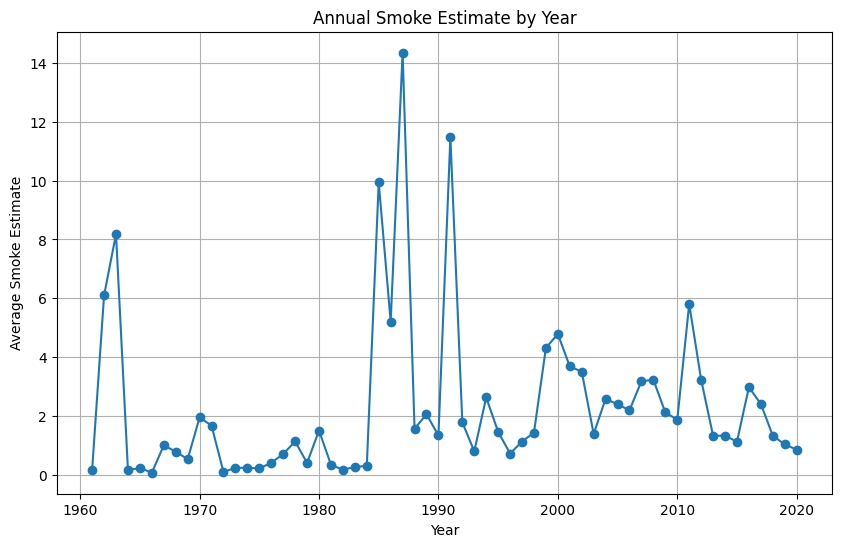

In [30]:
# Plot using pandas
annual_smoke_estimate.plot(kind='line', figsize=(10, 6), marker='o', title='Annual Smoke Estimate by Year')
plt.xlabel('Year')
plt.ylabel('Average Smoke Estimate')
plt.grid(True)
plt.show()

The maximum fire smoke was between the year 2015 to 2020 and over the following years the peaks are intermitent. With an overall constant trend with minor fluctuations.

### APPENDIX
The commented code logic below is to compute distances of fire from Alexandria which runs on a single core.

In [ ]:
# # below code will run on a single core - which takes about 112 minutes to complete and 
# # generate the two dataframes for shortest and avergare 
# # distance from the fire.

# from compute_distance import shortest_distance_from_place_to_fire_perimeter, average_distance_from_place_to_fire_perimeter, convert_ring_to_epsg4326

# json_structure = {'wild_fire_name': '', 'distance': None, 'size': None, 'latlon': (None, None), 'year': ''}
# json_structure_error = {'wild_fire_name': '', 'error': ''}

# shortest_dist_650_wf = {}
# shortest_error_wf = {}

# avg_dist_650_wf = {}
# avg_error_wf = {}

# for wf_feature in feature_list:
#     #print(f"{place['city']}")
#     wf_year = wf_feature['attributes']['Fire_Year']
#     wf_name = wf_feature['attributes']['Listed_Fire_Names'].split(',')[0]
#     wf_size = wf_feature['attributes']['GIS_Acres']
#     wf_type = wf_feature['attributes']['Assigned_Fire_Type']
#     if 'rings' in wf_feature['geometry']:
#         ring_data = wf_feature['geometry']['rings'][0]
#     elif 'curveRings' in wf_feature['geometry']:
#         ring_data = wf_feature['geometry']['curveRings'][0]
#     else:
#         raise Exception("HEY! No compatible geometry in this fire data!!!")
    
#     print(f"---------------Processing for {wf_name} and year {wf_year}---------------")
#     #
#     #     Compute using the shortest distance to any point on the perimeter
#     #
#     if wf_year >= 1961 and wf_year<=2021:
#         try:
#             distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
#             if distance[0] <= 650.0:
#                 print(f"The closest distance of fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was {distance[0]:1.2f} miles to {place['city']}")
#                 print(f"\tThe cloest perimiter point lat,lon {distance[1][0]},{distance[1][1]}")

#                 # Append data to shortest_dist_650_wf
#                 json_structure['wild_fire_name'] = wf_name
#                 json_structure['distance'] = distance[0]
#                 json_structure['size'] = wf_size
#                 json_structure['latlon'] = (distance[1][0], distance[1][1])
#                 json_structure['year'] = wf_year
                
#                 if shortest_dist_650_wf[wf_year]:
#                     shortest_dist_650_wf[wf_year].append(json_structure)
#                 else:
#                     shortest_dist_650_wf[wf_year] = []

#         except Exception as e:
#             # Append data to shortest_dist_650_wf
#             json_structure_error['wild_fire_name'] = wf_name
#             json_structure_error['error'] = str(e)
            
#             if shortest_error_wf[wf_year]:
#                     shortest_error_wf[wf_year].append(json_structure)
#             else:
#                 shortest_error_wf[wf_year] = []

#         #
#         #     Compute using the average distance to all points on the perimeter
#         #
#         try:
#             distance = average_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)
#             if distance <= 650.0:
#                 print(f"Fire '{wf_name}' ({wf_size:1.2f} acres) from {wf_year} was an average {distance:1.2f} miles to {place['city']}")
#                 # just get a location to print thats on the ring (perimeter)
#                 ring = convert_ring_to_epsg4326(ring_data)
#                 perimeter_start = ring[0]
#                 # print(f"\tOne perimiter point lat,lon {perimeter_start[0]},{perimeter_start[1]}")
#                 # Append data to average_dist_650_wf
#                 json_structure['wild_fire_name'] = wf_name
#                 json_structure['distance'] = distance
#                 json_structure['size'] = wf_size
#                 json_structure['latlon'] = (perimeter_start[0], perimeter_start[1])
#                 json_structure['year'] = wf_year

#                 if avg_dist_650_wf[wf_year]:
#                     avg_dist_650_wf[wf_year].append(json_structure)
#                 else:
#                     avg_dist_650_wf[wf_year] = []
#         except Exception as e:
#             json_structure_error['wild_fire_name'] = wf_name
#             json_structure_error['error'] = str(e)

#             if avg_error_wf[wf_year]:
#                     avg_error_wf[wf_year].append(json_structure)
#             else:
#                 avg_error_wf[wf_year] = []

#     print()
